In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Inputs

In [51]:
# Constants
DAYS = 30  
INITIAL_CUSTOMERS = 1.02e6  
INITIAL_CAPITAL = 15e6 
AOV = 300  
PROFIT_MARGIN = 0.2  # 20% profit margin
M0 = 5e6  

In [52]:
#Calculating Weekly order frequency per customer
df_order_freq = pd.read_csv("order_frequency_data.csv")
WEEKLY_ORDER_FREQUENCY = df_order_freq['order_frequency_per_week'].mean()
print(WEEKLY_ORDER_FREQUENCY)  #Average orders per customer per week

1.6667478006884802


In [53]:
WEEKLY_ORDER_FREQUENCY = 1.6667478006884802

# Functions

In [54]:
# Probability of delivery within 10 mins
def calculate_probability(mi):
    return 0.8 * (1.25 - np.exp(-mi / 5e6))

# Growth factor
def calculate_growth(p, mi): 
    return (38 / 40) + (1 / 40) * ((0.45 + p)**0.3 + ((mi/1e6) / ((M0/1e6) + 1))**0.05)

# Daily profit
def calculate_daily_profit(customers):
    total_orders = customers * WEEKLY_ORDER_FREQUENCY / 7  # Orders per day
    return total_orders * AOV * PROFIT_MARGIN

In [55]:
# Find the best combination of mi and Mi for a given budget
def find_best_combination(budget):
    best_mi, best_mi_marketing, max_growth = 0, 0, 0
    step = 1e6
    for mi in np.arange(0, budget + step, step):
        mi_marketing = budget - mi
        p = calculate_probability(mi)
        growth = calculate_growth(p, mi_marketing)
        if growth > max_growth:
            max_growth = growth
            best_mi = mi
            best_mi_marketing = mi_marketing
    return best_mi, best_mi_marketing, max_growth

In [77]:
#Example
print("mi,MI, G for different budget")
print("budget 14 million : ",find_best_combination(14e6))
print("budget 13 million : ",find_best_combination(13e6))
print("budget 12 million : ",find_best_combination(12e6))
print("budget 11 million : ",find_best_combination(11e6))
print("budget 10 million : ",find_best_combination(10e6))
print("budget 9 million : ",find_best_combination(9e6))
print("budget 8 million : ",find_best_combination(8e6))

mi,MI, G for different budget
budget 14 million :  (8000000.0, 6000000.0, 1.0019751330146462)
budget 13 million :  (7000000.0, 6000000.0, 1.0017483171933046)
budget 12 million :  (7000000.0, 5000000.0, 1.0015214508838817)
budget 11 million :  (7000000.0, 4000000.0, 1.0012465888261186)
budget 10 million :  (6000000.0, 4000000.0, 1.0009633210007243)
budget 9 million :  (6000000.0, 3000000.0, 1.0006134575910315)
budget 8 million :  (5000000.0, 3000000.0, 1.0002575827991629)


In [56]:
# Main function to simulate the approach
def simulate_growth_strategy(daily_budgets):
    
    customers = INITIAL_CUSTOMERS
    capital = INITIAL_CAPITAL
    results = []

    for day in range(1, DAYS + 1):
        # Get the daily budget
        budget = daily_budgets[day - 1]

        # Find the best combination of mi and Mi for the budget
        mi, mi_marketing, growth = find_best_combination(budget)

        # Calculate end-of-day values
        p = calculate_probability(mi)
        customers_end = customers * growth
        profit = calculate_daily_profit(customers_end)
        new_capital = capital - mi - mi_marketing + profit

        # Store the day's results
        results.append({
            "Day": day,
            "Capital Start of Day": int(capital),
            "Ci-1 (Customers Start)": int(customers),
            "mi (Delivery Spend)": int(mi),
            "Mi (Marketing Spend)": int(mi_marketing),
            "Growth Factor (G)": round(growth, 4),
            "Ci (Customers End)": int(customers_end),
            "Total Orders": int(customers_end * WEEKLY_ORDER_FREQUENCY / 7),
            "Capital End of Day": int(new_capital),
            "Growth Rate": int(new_capital - capital)
        })

        # Update values for the next day
        customers = customers_end
        capital = new_capital

    # Convert results to a DataFrame
    return pd.DataFrame(results)

In [57]:
# Function to visualize the results
def visualize_results(results_df):
    # customer growth over 30 days
    plt.figure(figsize=(10, 6))
    plt.plot(results_df["Day"], results_df["Ci (Customers End)"], marker="o", label="Customers End of Day")
    plt.title("Customer Growth Over 30 Days", fontsize=14)
    plt.xlabel("Day", fontsize=12)
    plt.ylabel("Number of Customers", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.show()

    # capital growth over 30 days
    plt.figure(figsize=(10, 6))
    plt.plot(results_df["Day"], results_df["Capital Start of Day"], label="Capital Start of Day", marker="o")
    plt.plot(results_df["Day"], results_df["Capital End of Day"], label="Capital End of Day", marker="o")
    plt.title("Capital Growth Over 30 Days", fontsize=14)
    plt.xlabel("Day", fontsize=12)
    plt.ylabel("Capital (INR)", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.show()

    # bar chart for daily spending
    plt.figure(figsize=(10, 6))
    plt.bar(results_df["Day"], results_df["mi (Delivery Spend)"], label="Delivery Spend (mi)", color="lightblue")
    plt.bar(results_df["Day"], results_df["Mi (Marketing Spend)"], bottom=results_df["mi (Delivery Spend)"], label="Marketing Spend (Mi)", color="orange")
    plt.title("Daily Spending Breakdown", fontsize=14)
    plt.xlabel("Day", fontsize=12)
    plt.ylabel("Spending (INR)", fontsize=12)
    plt.legend()
    plt.show()

    # Line chart for growth rate
    plt.figure(figsize=(10, 6))
    plt.plot(results_df["Day"], results_df["Growth Rate"], color="green", marker="o", label="Growth Rate")
    plt.title("Daily Growth Rate of Capital", fontsize=14)
    plt.xlabel("Day", fontsize=12)
    plt.ylabel("Growth Rate (INR)", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.show()

    # bar chart for capital at EOD
    plt.figure(figsize=(10, 6))
    plt.bar(results_df["Day"],results_df["Capital End of Day"],label="Capital at End of Day (INR)", color="green")
    plt.title("Distribution of Capital at End of Day", fontsize=14)
    plt.xlabel("Day", fontsize=12)
    plt.ylabel("Capital End of Day", fontsize=12)
    plt.legend()
    plt.show()

# Strategy1

In [60]:
# Increase spending after every few days

In [65]:
daily_budgets1 = [8e6] * 4 + [9e6] * 4 + [10e6] * 4 + [11e6] * 4 + [12e6] * 4 + [13e6] * 4 + [14e6] * 6
# Simulate the strategy and visualize the results
results_df1 = simulate_growth_strategy(daily_budgets1)
results_df1

,Day,Capital Start of Day,Ci-1 (Customers Start),mi (Delivery Spend),Mi (Marketing Spend),Growth Factor (G),Ci (Customers End),Total Orders,Capital End of Day,Growth Rate
0,1,15000000,1020000,5000000,3000000,1.0003,1020262,242931,21575891,6575891
1,2,21575891,1020262,5000000,3000000,1.0003,1020525,242994,28155537,6579645
2,3,28155537,1020525,5000000,3000000,1.0003,1020788,243056,34738938,6583401
3,4,34738938,1020788,5000000,3000000,1.0003,1021051,243119,41326096,6587157
4,5,41326096,1021051,6000000,3000000,1.0006,1021677,243268,46922203,5596106
5,6,46922203,1021677,6000000,3000000,1.0006,1022304,243417,52527263,5605060
6,7,52527263,1022304,6000000,3000000,1.0006,1022931,243567,58141283,5614020
7,8,58141283,1022931,6000000,3000000,1.0006,1023559,243716,63764268,5622985
8,9,63764268,1023559,6000000,4000000,1.0010,1024545,243951,68401340,4637071
9,10,68401340,1024545,6000000,4000000,1.0010,1025532,244186,73052512,4651172


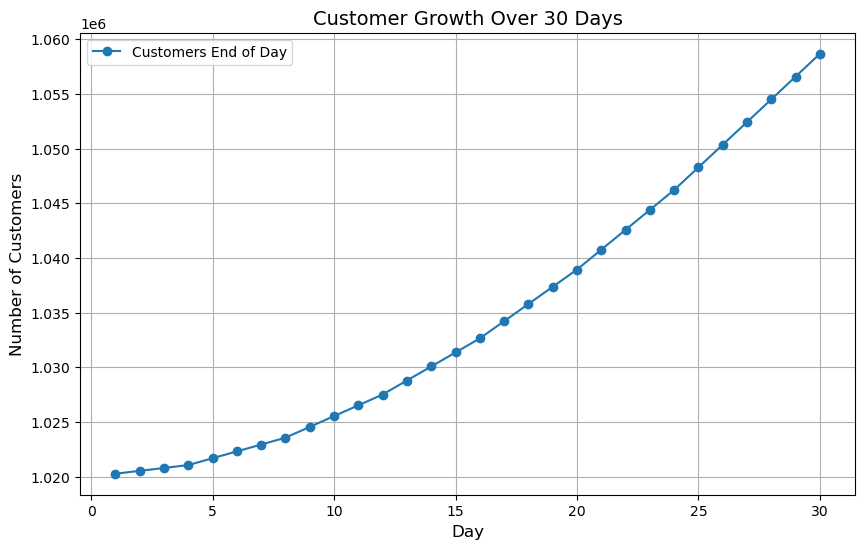

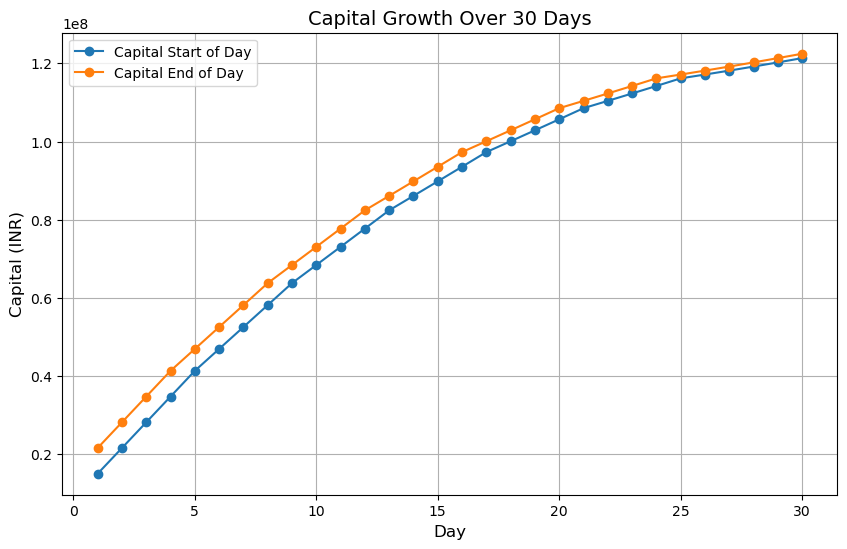

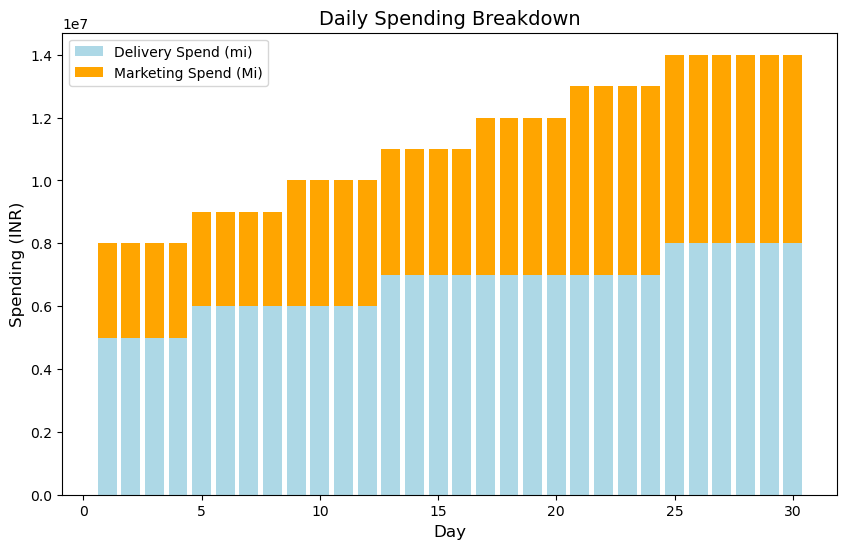

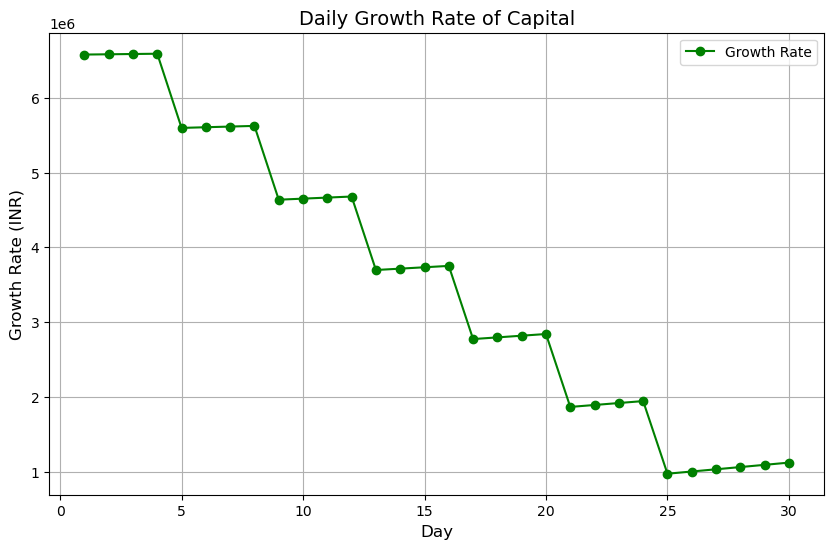

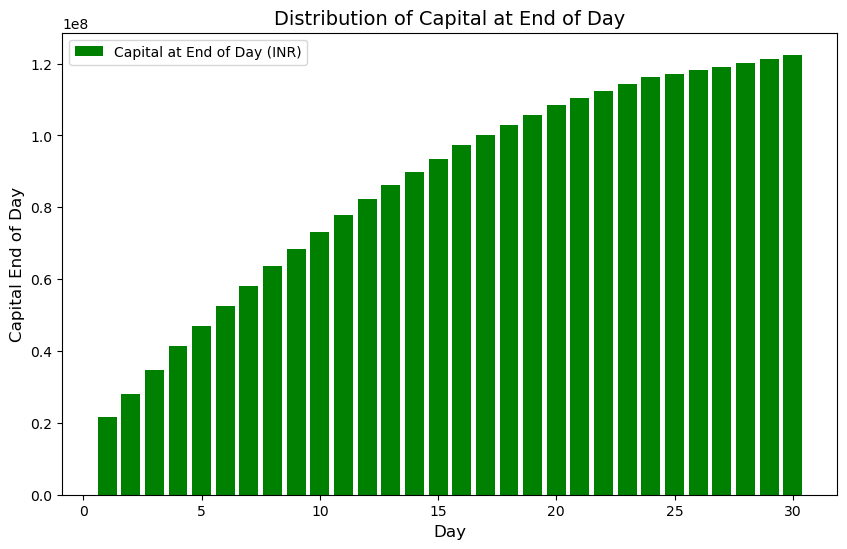

In [66]:
visualize_results(results_df1)

# Final Strategy - Recommended

- Higher Spending in Early Days: Spend 14 million per day for the first 6 days. This helps grow the customer base quickly, which is important for increasing daily profits.
- Gradual Reduction in Budget: After the first 6 days, reduce spending step by step. This ensures that capital growth improves while still maintaining G > 1.


In [67]:
daily_budgets_final = [14e6] * 6 + [13e6] * 4 + [12e6] * 4 + [11e6] * 4 + [10e6] * 4 + [9e6] * 4 + [8e6] * 4
# Simulate the strategy and visualize the results
results_df_final = simulate_growth_strategy(daily_budgets_final)
results_df_final

,Day,Capital Start of Day,Ci-1 (Customers Start),mi (Delivery Spend),Mi (Marketing Spend),Growth Factor (G),Ci (Customers End),Total Orders,Capital End of Day,Growth Rate
0,1,15000000,1020000,8000000,6000000,1.0020,1022014,243348,15600919,600919
1,2,15600919,1022014,8000000,6000000,1.0020,1024033,243829,16230678,629758
2,3,16230678,1024033,8000000,6000000,1.0020,1026055,244310,16889332,658654
3,4,16889332,1026055,8000000,6000000,1.0020,1028082,244793,17576939,687607
4,5,17576939,1028082,8000000,6000000,1.0020,1030113,245276,18293556,716617
5,6,18293556,1030113,8000000,6000000,1.0020,1032147,245761,19039241,745684
6,7,19039241,1032147,7000000,6000000,1.0017,1033952,246191,20810705,1771464
7,8,20810705,1033952,7000000,6000000,1.0017,1035759,246621,22607995,1797289
8,9,22607995,1035759,7000000,6000000,1.0017,1037570,247052,24431155,1823160
9,10,24431155,1037570,7000000,6000000,1.0017,1039384,247484,26280231,1849075


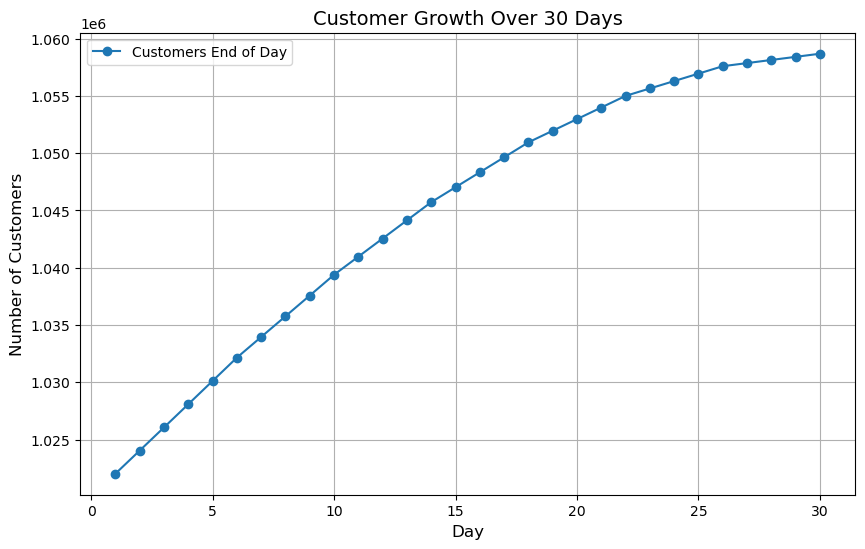

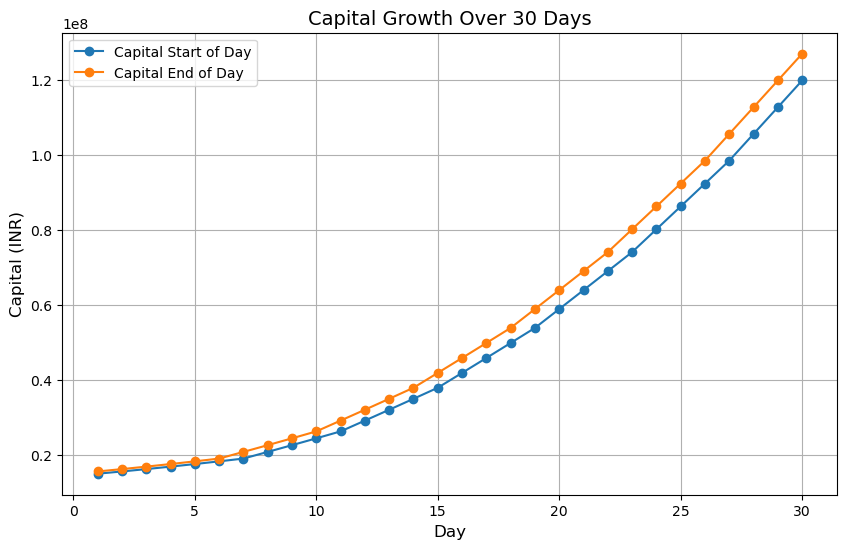

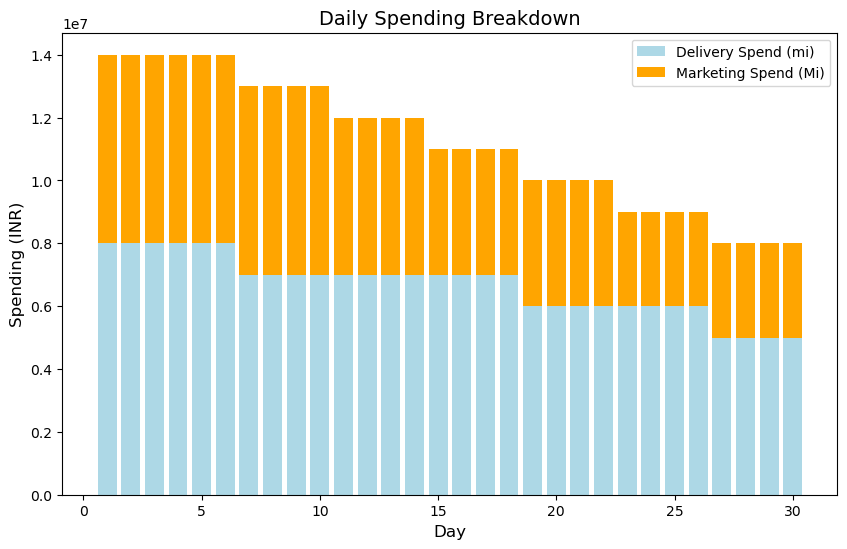

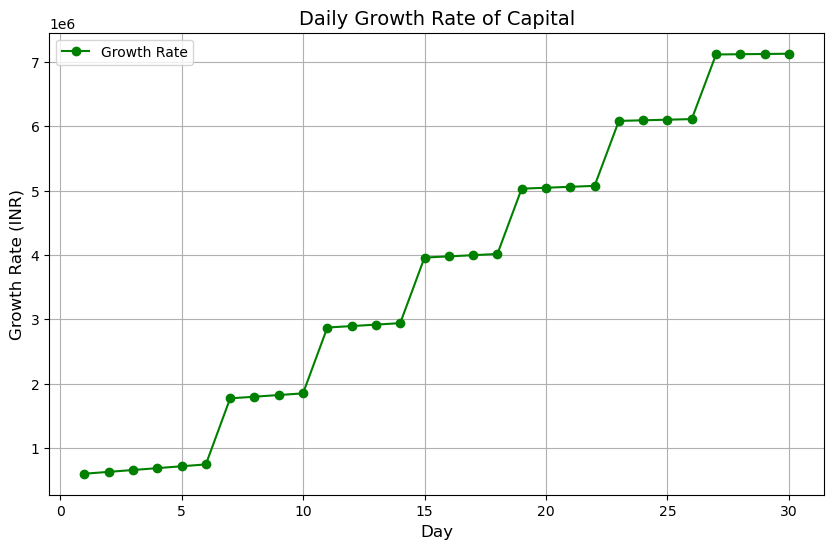

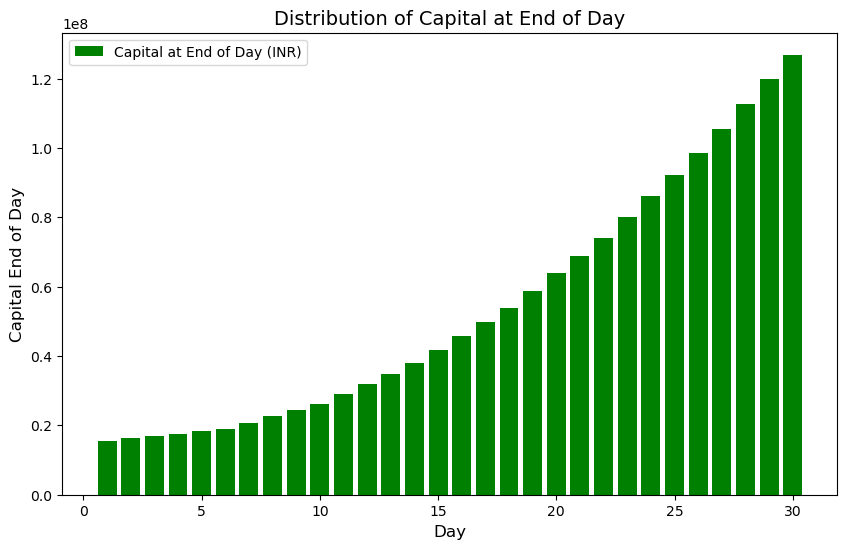

In [68]:
visualize_results(results_df_final)

# Strategy1 vs Final Strategy

Strategy 1

Final_customers = 1.05 million
Total money spent = 336 million
Final_capital = 122.4 million

Cons - Slower Customer Acquisition, Declining Growth Rate of capital

Strategy 2

Final_customers = 1.05 million
Total money spent = 336 million
Final_capital = 126.9 million

Pros - Faster customer acquisition, Increasing Growth Rate of Capital, More capital at End of month